In [1]:
!pip install -q sklearn
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from IPython.display import clear_output
import tensorflow as tf

## import data

In [ ]:
# load dataset
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dftest = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = dftrain.pop("survived")
y_test = dftest.pop("survived")

# statistical analysis
dftrain.describe()

# 627 entries and 9 features
dftrain.shape

## graphs

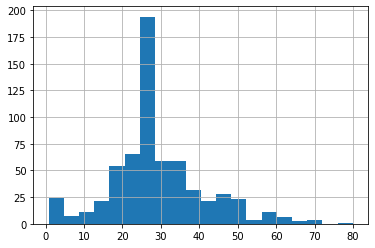

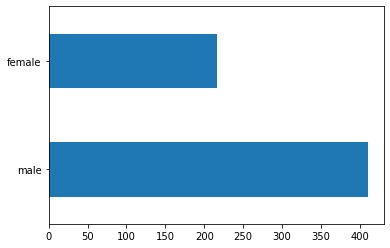

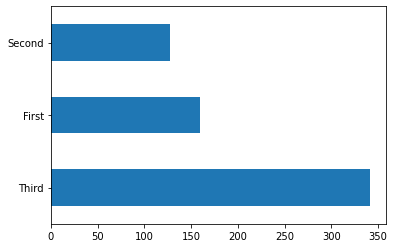

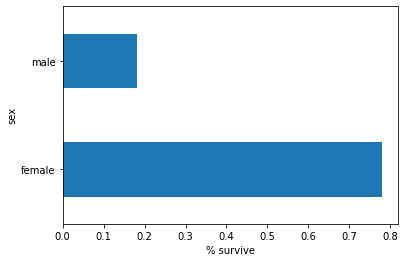

In [3]:
dftrain.age.hist(bins=20)
plt.show()

dftrain.sex.value_counts().plot(kind="barh")
plt.show()

dftrain["class"].value_counts().plot(kind="barh")
plt.show()

pd.concat([dftrain, y_train], axis=1).groupby("sex").survived.mean().plot(kind="barh").set_xlabel("% survive")
plt.show()

## feature engineering

In [4]:
CATEGORICAL_COLUMNS = ["sex", "n_siblings_spouses", "parch", "class", "deck",
                       "embark_town", "alone"]
NUMERIC_COLUMNS = ["age", "fare"]

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float16))

feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

## input function

In [5]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  # inner function, this will be returned
  def input_function():
    # create tf.data.Dataset object with data and its label
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      # randomize order of data
      ds = ds.shuffle(1000)
    # split dataset into batches of 32 and repeat process for number of epochs
    ds = ds.batch(batch_size).repeat(num_epochs)
    # return a batch of the dataset
    return ds 
  # return a function object for use
  return input_function

# call the input_function that was returned to us to get a dataset object we can feed to the model
train_input_fn = make_input_fn(dftrain, y_train)  
test_input_fn = make_input_fn(dftest, y_test, num_epochs=1, shuffle=False)

## create model & train

In [6]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(test_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
result["accuracy"]  # the result variable is simply a dict of stats about our model

0.74242425


## predict 


In [7]:
# get the prediction for one data point
result = list(linear_est.predict(test_input_fn))
print(dftest.loc[3])
print("survived: " + str(y_test.loc[3]))
print("predicted survival chance: " + str(result[3]["probabilities"][1]))

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpg_062gvj/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
sex                        female
age                            55
n_siblings_spouses              0
parch                           0
fare                           16
class                      Second
deck                      unknown
embark_town           Southampton
alone                           y
Name: 3, dtype: object
survived: 1
predicted survival chance: 0.85530263


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpg_062gvj/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


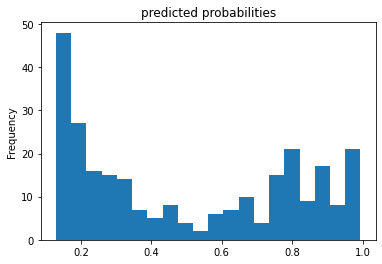

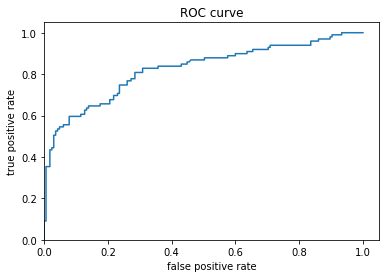

In [8]:
pred_dicts = list(linear_est.predict(test_input_fn))
probs = pd.Series([pred["probabilities"][1] for pred in pred_dicts])

# plot histogram
probs.plot(kind="hist", bins=20, title="predicted probabilities")
plt.show()

# plot roc curve
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.xlim(0,)
plt.ylim(0,)
plt.show()